In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
import seaborn as sns

In [2]:
import re

In [3]:
#pandas print options
pd.set_option('display.float_format', '{:.3f}'.format)

In [4]:
#pip install nbconvert[webpdf]

#  Loading and Checking data

In [5]:
purchase_behavior = pd.read_csv('data/QVI_purchase_behaviour.csv')
purchase_behavior

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
...,...,...,...
72632,2370651,MIDAGE SINGLES/COUPLES,Mainstream
72633,2370701,YOUNG FAMILIES,Mainstream
72634,2370751,YOUNG FAMILIES,Premium
72635,2370961,OLDER FAMILIES,Budget


In [6]:
purchase_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [7]:
print(purchase_behavior.groupby('LIFESTAGE')['LYLTY_CARD_NBR'].count().sort_values(ascending=False))

LIFESTAGE
RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LYLTY_CARD_NBR, dtype: int64


In [8]:
print(purchase_behavior.groupby('PREMIUM_CUSTOMER')['LYLTY_CARD_NBR'].count().sort_values(ascending=False))

PREMIUM_CUSTOMER
Mainstream    29245
Budget        24470
Premium       18922
Name: LYLTY_CARD_NBR, dtype: int64


In [9]:
segmentation = purchase_behavior.pivot_table(index = 'LIFESTAGE',
                                    columns = 'PREMIUM_CUSTOMER', values='LYLTY_CARD_NBR', aggfunc = 'count')
segmentation

PREMIUM_CUSTOMER,Budget,Mainstream,Premium
LIFESTAGE,,,
MIDAGE SINGLES/COUPLES,1504,3340,2431
NEW FAMILIES,1112,849,588
OLDER FAMILIES,4675,2831,2274
OLDER SINGLES/COUPLES,4929,4930,4750
RETIREES,4454,6479,3872
YOUNG FAMILIES,4017,2728,2433
YOUNG SINGLES/COUPLES,3779,8088,2574


In [10]:
#conda install openpyxl

In [11]:
transactions = pd.read_excel('data/QVI_transaction_data.xlsx')
transactions

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.000
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.300
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.900
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.000
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.800
...,...,...,...,...,...,...,...,...
264831,43533,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.800
264832,43325,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.400
264833,43410,272,272379,270187,51,Doritos Mexicana 170g,2,8.800
264834,43461,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.800


In [12]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


I don't see any missing values from this perspective. I also don't see wrong data types, everything looks fair. On the other hand i see some useless columns which i will most likely delete a bit later. 

Let's check the data distribution and see if there are outliers.

In [13]:
plt.style.use('seaborn-v0_8-darkgrid')

array([[<Axes: title={'center': 'PROD_NBR'}>,
        <Axes: title={'center': 'STORE_NBR'}>],
       [<Axes: title={'center': 'PROD_QTY'}>,
        <Axes: title={'center': 'TOT_SALES'}>]], dtype=object)

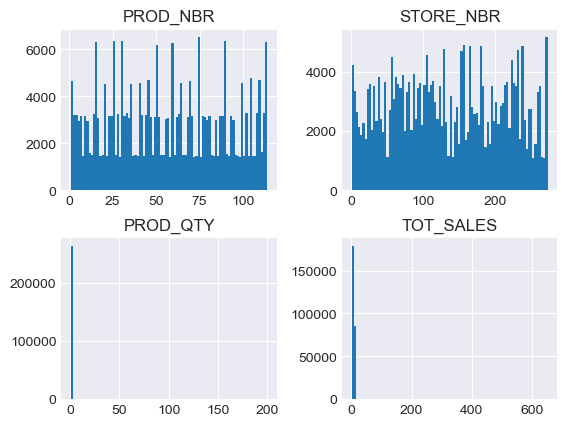

In [14]:
transactions[['PROD_NBR', 'STORE_NBR', 'PROD_QTY', 'TOT_SALES']].hist(bins=90)

Well, distribution among products seems ok and trustworthy. Concerning product quantity and total sales i'd like to question data credibility. Possible options are: 1)errors, 2)formating errors (extra zeroes) 3) we have some wholesale purchasers (but then we probably would detect similarities (same loyalty cards or even groups). Also we need to see if same rows contain both quantity and total sales anomalies.

Let's expetriment with values of quantity / sales and check this. 

In [15]:
anomalies = transactions[transactions['TOT_SALES']>28]
anomalies

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
72,43331,96,96203,96025,7,Smiths Crinkle Original 330g,5,28.500
5179,43327,94,94148,93390,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.500
17110,43328,172,172239,174254,7,Smiths Crinkle Original 330g,5,28.500
32248,43601,66,66014,63251,23,Cheezels Cheese 330g,5,28.500
55558,43599,190,190113,190914,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.500
69496,43327,49,49303,45789,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.500
69762,43331,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.000
69763,43605,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.000
81110,43329,181,181129,183109,23,Cheezels Cheese 330g,5,28.500
81301,43326,243,243345,247084,16,Smiths Crinkle Chips Salt & Vinegar 330g,5,28.500


Well, it all looks credible except for 2 entries: 
69762	43331	226	226000	226201	4	Dorito Corn Chp Supreme 380g	200	650.0
69763	43605	226	226000	226210	4	Dorito Corn Chp Supreme 380g	200	650.0

What I want to check: 
1) other purchases of this client 
2) other seles of exactly these chips as they seem around 40% cheaper (even though i would hardly believe 40% discount would make someone buy 200 packs twice in 2 days)

other takeaways: 

3) maybe we should also create "price_per_pack" category. 
4) And I would also think about 'price_per_kg' catеgory to check price sensitivity but for this we need to parse all prod_names and retrieve weigth form there and put it into a separate column. 
5) and going even further we could probably classify chips by 'price_per_kg' if we see some interestong patterns.

In [16]:
print(transactions[transactions['LYLTY_CARD_NBR']==226000])

        DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
69762  43331        226          226000  226201         4   
69763  43605        226          226000  226210         4   

                              PROD_NAME  PROD_QTY  TOT_SALES  
69762  Dorito Corn Chp     Supreme 380g       200    650.000  
69763  Dorito Corn Chp     Supreme 380g       200    650.000  


Ok, we should probably get rid of this. Even if all values in these entries are x100 here we wouldn't get too much value from it so - probably no need to check this assumtion. 

In [17]:
transactions['PACK_PRICE'] = transactions['TOT_SALES']/transactions['PROD_QTY']

In [18]:
display(transactions[transactions['PROD_NBR']==4])

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_PRICE
41,43605,55,55073,48887,4,Dorito Corn Chp Supreme 380g,1,3.250,3.250
67,43328,83,83186,83162,4,Dorito Corn Chp Supreme 380g,2,6.500,3.250
157,43599,212,212203,211586,4,Dorito Corn Chp Supreme 380g,1,3.250,3.250
199,43330,269,269175,266095,4,Dorito Corn Chp Supreme 380g,2,6.500,3.250
236,43407,3,3164,1779,4,Dorito Corn Chp Supreme 380g,2,13.000,6.500
...,...,...,...,...,...,...,...,...,...
264457,43337,255,255218,254791,4,Dorito Corn Chp Supreme 380g,1,6.500,6.500
264470,43318,255,255470,255094,4,Dorito Corn Chp Supreme 380g,1,6.500,6.500
264536,43379,259,259056,257776,4,Dorito Corn Chp Supreme 380g,2,13.000,6.500
264584,43336,261,261292,260939,4,Dorito Corn Chp Supreme 380g,2,13.000,6.500


In [19]:
print(transactions[transactions['PROD_NBR']==4]['PACK_PRICE'].value_counts())

6.500    3054
3.250     131
Name: PACK_PRICE, dtype: int64


Another fun fact - the price is usually 6.50 per pack but really seldom there is a 50% price reduction. 

New idea - to check how price redictions affect average consumption. What can we calculate: 
1) Daily consumption
2) Averge packs bought per purchase
3) Discounts preferred by categories 

Hows ? 1) Need to do discount day. probably separate for each chips and stores (which will probably be too much and unnecessary) but if discount days matc (which i highly doubt) we would probably have sth to work with  2)(sum/count) for groupped by discount 3) create max price column apply function if price < max_price then 1 else 0

# Merging and leaving only necesary columns

In [20]:
data = purchase_behavior.merge(transactions, on = 'LYLTY_CARD_NBR', how = 'outer')

In [21]:
data.drop('TXN_ID', axis = 1)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_PRICE
0,1000,YOUNG SINGLES/COUPLES,Premium,43390,1,5,Natural Chip Compny SeaSalt175g,2,6.000,3.000
1,1002,YOUNG SINGLES/COUPLES,Mainstream,43359,1,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.700,2.700
2,1003,YOUNG FAMILIES,Budget,43531,1,52,Grain Waves Sour Cream&Chives 210G,1,3.600,3.600
3,1003,YOUNG FAMILIES,Budget,43532,1,106,Natural ChipCo Hony Soy Chckn175g,1,3.000,3.000
4,1004,OLDER SINGLES/COUPLES,Mainstream,43406,1,96,WW Original Stacked Chips 160g,1,1.900,1.900
...,...,...,...,...,...,...,...,...,...,...
264831,2370701,YOUNG FAMILIES,Mainstream,43442,88,24,Grain Waves Sweet Chilli 210g,2,7.200,3.600
264832,2370751,YOUNG FAMILIES,Premium,43374,88,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.200,4.600
264833,2370961,OLDER FAMILIES,Budget,43397,88,70,Tyrrells Crisps Lightly Salted 165g,2,8.400,4.200
264834,2370961,OLDER FAMILIES,Budget,43400,88,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.200,5.100


In [22]:
#data

# Data preparation

So, what columns would I like to add?
- weight
- price per kg
- max price
- is discount 
- price categores
- weight categories

## Drops

In [23]:
data.drop(data[data['LYLTY_CARD_NBR'] == 226000].index, inplace=True)

In [24]:
data

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_PRICE
0,1000,YOUNG SINGLES/COUPLES,Premium,43390,1,1,5,Natural Chip Compny SeaSalt175g,2,6.000,3.000
1,1002,YOUNG SINGLES/COUPLES,Mainstream,43359,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.700,2.700
2,1003,YOUNG FAMILIES,Budget,43531,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.600,3.600
3,1003,YOUNG FAMILIES,Budget,43532,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.000,3.000
4,1004,OLDER SINGLES/COUPLES,Mainstream,43406,1,5,96,WW Original Stacked Chips 160g,1,1.900,1.900
...,...,...,...,...,...,...,...,...,...,...,...
264831,2370701,YOUNG FAMILIES,Mainstream,43442,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.200,3.600
264832,2370751,YOUNG FAMILIES,Premium,43374,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.200,4.600
264833,2370961,OLDER FAMILIES,Budget,43397,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.400,4.200
264834,2370961,OLDER FAMILIES,Budget,43400,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.200,5.100


the shape is correct now. 

In [25]:
data[(data['TOT_SALES'] < 1) | (data['PROD_QTY'] < 1) | (data['PACK_PRICE'] < 1)]

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_PRICE


We don't have any missing values or outliers left.

array([[<Axes: title={'center': 'PROD_QTY'}>,
        <Axes: title={'center': 'TOT_SALES'}>]], dtype=object)

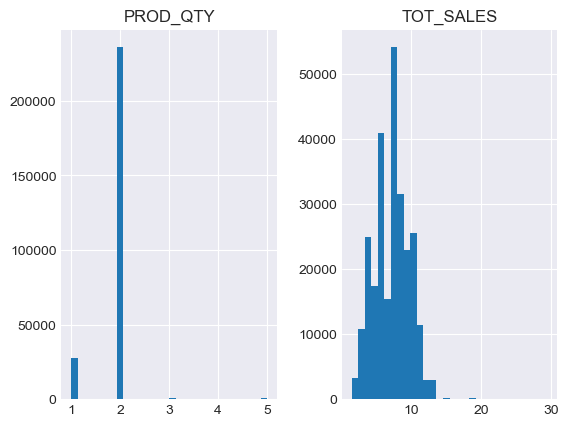

In [26]:
data[['PROD_QTY', 'TOT_SALES']].hist(bins=30)

## Feature engineering

Now that looks credible. So average client buys 2 packs and pays approximately 7 dollars... 

In [27]:
data['WEIGHT'] = data['PROD_NAME'].str.extract(r'(\d+)g', flags=re.IGNORECASE).astype(int)/1000

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264834 entries, 0 to 264835
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   LIFESTAGE         264834 non-null  object 
 2   PREMIUM_CUSTOMER  264834 non-null  object 
 3   DATE              264834 non-null  int64  
 4   STORE_NBR         264834 non-null  int64  
 5   TXN_ID            264834 non-null  int64  
 6   PROD_NBR          264834 non-null  int64  
 7   PROD_NAME         264834 non-null  object 
 8   PROD_QTY          264834 non-null  int64  
 9   TOT_SALES         264834 non-null  float64
 10  PACK_PRICE        264834 non-null  float64
 11  WEIGHT            264834 non-null  float64
dtypes: float64(3), int64(6), object(3)
memory usage: 26.3+ MB


No missing values in weight - looks great! What a great format of data! Pure pleasure working with it. 

In [29]:
#data[['WEIGHT']].hist(bins=30)

In [30]:
data['KG_PRICE'] = data['PACK_PRICE']/data['WEIGHT']

array([[<Axes: title={'center': 'WEIGHT'}>,
        <Axes: title={'center': 'KG_PRICE'}>]], dtype=object)

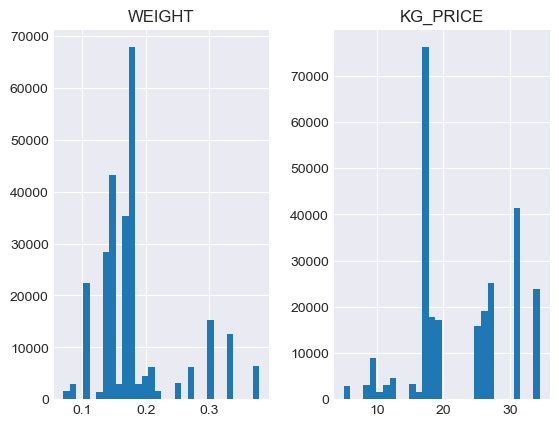

In [31]:
data[['WEIGHT', 'KG_PRICE']].hist(bins=30)

Should there be issues with prices above 30 usd per kg? 

In [32]:
display(data[data['KG_PRICE']>=30])

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_PRICE,WEIGHT,KG_PRICE
6,1007,YOUNG SINGLES/COUPLES,Budget,43438,1,7,49,Infuzions SourCream&Herbs Veg Strws 110g,1,3.800,3.800,0.110,34.545
13,1011,OLDER SINGLES/COUPLES,Mainstream,43435,1,14,49,Infuzions SourCream&Herbs Veg Strws 110g,1,3.800,3.800,0.110,34.545
16,1012,OLDER FAMILIES,Mainstream,43635,1,17,3,Kettle Sensations Camembert & Fig 150g,1,4.600,4.600,0.150,30.667
20,1016,OLDER FAMILIES,Mainstream,43625,1,21,63,Kettle 135g Swt Pot Sea Salt,1,4.200,4.200,0.135,31.111
21,1018,YOUNG SINGLES/COUPLES,Mainstream,43346,1,22,3,Kettle Sensations Camembert & Fig 150g,1,4.600,4.600,0.150,30.667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264824,2330501,OLDER SINGLES/COUPLES,Budget,43636,77,236780,63,Kettle 135g Swt Pot Sea Salt,1,4.200,4.200,0.135,31.111
264825,2370001,OLDER SINGLES/COUPLES,Premium,43322,88,240064,102,Kettle Mozzarella Basil & Pesto 175g,2,10.800,5.400,0.175,30.857
264826,2370181,YOUNG SINGLES/COUPLES,Mainstream,43314,88,240146,36,Kettle Chilli 175g,2,10.800,5.400,0.175,30.857
264829,2370581,OLDER SINGLES/COUPLES,Budget,43460,88,240318,9,Kettle Tortilla ChpsBtroot&Ricotta 150g,2,9.200,4.600,0.150,30.667


In [33]:
display(data[data['KG_PRICE']<=5])

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_PRICE,WEIGHT,KG_PRICE
124,1114,OLDER FAMILIES,Premium,43351,1,131,76,Woolworths Medium Salsa 300g,2,3.000,1.500,0.300,5.000
139,1124,RETIREES,Mainstream,43447,1,148,35,Woolworths Mild Salsa 300g,1,1.500,1.500,0.300,5.000
157,1146,YOUNG SINGLES/COUPLES,Premium,43379,1,167,35,Woolworths Mild Salsa 300g,2,3.000,1.500,0.300,5.000
163,1150,YOUNG SINGLES/COUPLES,Budget,43386,1,173,35,Woolworths Mild Salsa 300g,1,1.500,1.500,0.300,5.000
191,1173,RETIREES,Mainstream,43457,1,202,76,Woolworths Medium Salsa 300g,2,3.000,1.500,0.300,5.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
263942,271188,RETIREES,Budget,43564,271,269341,35,Woolworths Mild Salsa 300g,2,3.000,1.500,0.300,5.000
264153,271224,YOUNG FAMILIES,Premium,43473,271,269554,35,Woolworths Mild Salsa 300g,2,3.000,1.500,0.300,5.000
264176,271229,YOUNG FAMILIES,Mainstream,43420,271,269578,76,Woolworths Medium Salsa 300g,2,3.000,1.500,0.300,5.000
264177,271229,YOUNG FAMILIES,Mainstream,43461,271,269579,35,Woolworths Mild Salsa 300g,2,3.000,1.500,0.300,5.000


I'd probably ask someone about the expensive ones, however i don't see any pattern here or room for typos. And it's almost 25% of our dataset - so it probably should be fine. Just unusual.  

what's left? 

1) price categories: <=5 usd/kg, <14 usd/kg, < 22 uds/kg, >=22usd/kg 

2) weight categories: <= 50, <= 100, <= 180, <= 250, >=250

3) max price for each PROD_NBR

4) is discount 

In [34]:
def price_category(price):
    if price <= 5:
        return 'super cheap'
    elif price <= 14:
        return 'below average'
    elif price <= 22:
        return 'average'
    elif price > 22:
        return 'expensive'

In [35]:
data['PRICE_CAT'] = data['KG_PRICE'].apply(price_category)

In [36]:
def weight_category(weight):
    if weight <= .050:
        return 'small'
    elif weight <= .100:
        return 'regular'
    elif weight <= .180:
        return 'big'
    elif weight <= .250:
        return 'XL'
    elif weight > .250:
        return 'XXL'

In [37]:
data['WEIGHT_CAT'] = data['WEIGHT'].apply(weight_category)

In [38]:
data

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_PRICE,WEIGHT,KG_PRICE,PRICE_CAT,WEIGHT_CAT
0,1000,YOUNG SINGLES/COUPLES,Premium,43390,1,1,5,Natural Chip Compny SeaSalt175g,2,6.000,3.000,0.175,17.143,average,big
1,1002,YOUNG SINGLES/COUPLES,Mainstream,43359,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.700,2.700,0.150,18.000,average,big
2,1003,YOUNG FAMILIES,Budget,43531,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.600,3.600,0.210,17.143,average,XL
3,1003,YOUNG FAMILIES,Budget,43532,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.000,3.000,0.175,17.143,average,big
4,1004,OLDER SINGLES/COUPLES,Mainstream,43406,1,5,96,WW Original Stacked Chips 160g,1,1.900,1.900,0.160,11.875,below average,big
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264831,2370701,YOUNG FAMILIES,Mainstream,43442,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.200,3.600,0.210,17.143,average,XL
264832,2370751,YOUNG FAMILIES,Premium,43374,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.200,4.600,0.150,30.667,expensive,big
264833,2370961,OLDER FAMILIES,Budget,43397,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.400,4.200,0.165,25.455,expensive,big
264834,2370961,OLDER FAMILIES,Budget,43400,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.200,5.100,0.300,17.000,average,XXL


In [39]:
#def find_discount(price, max_price):
#    if price == max_price:
#        return 0
#    elif price < max_price:
#        return 1

In [40]:
print(data['PROD_NAME'].value_counts())

Kettle Mozzarella   Basil & Pesto 175g      3304
Kettle Tortilla ChpsHny&Jlpno Chili 150g    3296
Cobs Popd Swt/Chlli &Sr/Cream Chips 110g    3269
Tyrrells Crisps     Ched & Chives 165g      3268
Cobs Popd Sea Salt  Chips 110g              3265
                                            ... 
RRD Pc Sea Salt     165g                    1431
Woolworths Medium   Salsa 300g              1430
NCC Sour Cream &    Garden Chives 175g      1419
French Fries Potato Chips 175g              1418
WW Crinkle Cut      Original 175g           1410
Name: PROD_NAME, Length: 114, dtype: int64


In [41]:
max_prices = data.groupby('PROD_NAME')['PACK_PRICE'].max()
max_prices

PROD_NAME
Burger Rings 220g                        2.300
CCs Nacho Cheese    175g                 2.100
CCs Original 175g                        2.100
CCs Tasty Cheese    175g                 2.100
Cheetos Chs & Bacon Balls 190g           3.300
                                          ... 
WW Sour Cream &OnionStacked Chips 160g   1.900
WW Supreme Cheese   Corn Chips 200g      1.900
Woolworths Cheese   Rings 190g           1.800
Woolworths Medium   Salsa 300g           1.500
Woolworths Mild     Salsa 300g           1.500
Name: PACK_PRICE, Length: 114, dtype: float64

In [42]:
data['MAX_PRICE'] = data['PROD_NAME'].map(max_prices)

def find_discount(row):
    price = row['PACK_PRICE']
    max_price = row['MAX_PRICE']
    if price == max_price:
        return 0
    elif price < max_price:
        return 1

In [43]:
data['DISCOUNT'] = data['MAX_PRICE'] - data['PACK_PRICE']

In [44]:
data['IS_DISCOUNT'] = data['DISCOUNT'] > 0.05

In [45]:
data['IS_DISCOUNT'].value_counts()

False    264685
True        149
Name: IS_DISCOUNT, dtype: int64

In [46]:
data[data['IS_DISCOUNT'] == True]

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_PRICE,WEIGHT,KG_PRICE,PRICE_CAT,WEIGHT_CAT,MAX_PRICE,DISCOUNT,IS_DISCOUNT
83,1077,OLDER SINGLES/COUPLES,Premium,43601,1,88,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,4.600,2.300,0.150,15.333,average,big,4.600,2.300,True
369,1343,MIDAGE SINGLES/COUPLES,Budget,43605,1,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.900,1.450,0.170,8.529,below average,big,2.900,1.450,True
569,1502,YOUNG FAMILIES,Mainstream,43330,1,587,13,Red Rock Deli Thai Chilli&Lime 150g,2,2.700,1.350,0.150,9.000,below average,big,2.700,1.350,True
581,2006,OLDER FAMILIES,Mainstream,43329,2,598,36,Kettle Chilli 175g,2,5.400,2.700,0.175,15.429,average,big,5.400,2.700,True
678,2102,YOUNG SINGLES/COUPLES,Budget,43332,2,694,57,Old El Paso Salsa Dip Tomato Mild 300g,2,5.100,2.550,0.300,8.500,below average,XXL,5.100,2.550,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255909,261344,OLDER SINGLES/COUPLES,Mainstream,43327,261,261167,4,Dorito Corn Chp Supreme 380g,2,6.500,3.250,0.380,8.553,below average,XXL,6.500,3.250,True
259554,268450,OLDER SINGLES/COUPLES,Mainstream,43327,268,264899,4,Dorito Corn Chp Supreme 380g,1,3.250,3.250,0.380,8.553,below average,XXL,6.500,3.250,True
260730,269175,MIDAGE SINGLES/COUPLES,Budget,43330,269,266095,4,Dorito Corn Chp Supreme 380g,2,6.500,3.250,0.380,8.553,below average,XXL,6.500,3.250,True
261880,270095,OLDER SINGLES/COUPLES,Premium,43326,270,267251,4,Dorito Corn Chp Supreme 380g,1,3.250,3.250,0.380,8.553,below average,XXL,6.500,3.250,True


In [47]:
data[data['IS_DISCOUNT'] == True]['PROD_NAME'].value_counts()

Dorito Corn Chp     Supreme 380g            129
Kettle Tortilla ChpsFeta&Garlic 150g          2
Thins Chips Salt &  Vinegar 175g              2
Doritos Corn Chips  Cheese Supreme 170g       1
Kettle Sweet Chilli And Sour Cream 175g       1
Old El Paso Salsa   Dip Chnky Tom Ht300g      1
Kettle Sensations   Camembert & Fig 150g      1
Infuzions BBQ Rib   Prawn Crackers 110g       1
Grain Waves Sour    Cream&Chives 210G         1
Grain Waves         Sweet Chilli 210g         1
Pringles Sthrn FriedChicken 134g              1
Smiths Crinkle Cut  Chips Chicken 170g        1
RRD SR Slow Rst     Pork Belly 150g           1
Pringles Original   Crisps 134g               1
Kettle Original 175g                          1
Old El Paso Salsa   Dip Tomato Mild 300g      1
Kettle Chilli 175g                            1
Red Rock Deli Thai  Chilli&Lime 150g          1
Tyrrells Crisps     Ched & Chives 165g        1
Name: PROD_NAME, dtype: int64

So We literally have only 1 particular item that is subject discounts. In this case we will be unable to define how discount affect sales. I guess we have to abandon this topic for now despite having spent quite some time on it already.

Let's finilize creating or dataframe and delete all unnecessary columns

In [48]:
df = data.drop(['TXN_ID', 'MAX_PRICE', 'DISCOUNT', 'IS_DISCOUNT'], axis = 1)

In [49]:
df

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_PRICE,WEIGHT,KG_PRICE,PRICE_CAT,WEIGHT_CAT
0,1000,YOUNG SINGLES/COUPLES,Premium,43390,1,5,Natural Chip Compny SeaSalt175g,2,6.000,3.000,0.175,17.143,average,big
1,1002,YOUNG SINGLES/COUPLES,Mainstream,43359,1,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.700,2.700,0.150,18.000,average,big
2,1003,YOUNG FAMILIES,Budget,43531,1,52,Grain Waves Sour Cream&Chives 210G,1,3.600,3.600,0.210,17.143,average,XL
3,1003,YOUNG FAMILIES,Budget,43532,1,106,Natural ChipCo Hony Soy Chckn175g,1,3.000,3.000,0.175,17.143,average,big
4,1004,OLDER SINGLES/COUPLES,Mainstream,43406,1,96,WW Original Stacked Chips 160g,1,1.900,1.900,0.160,11.875,below average,big
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264831,2370701,YOUNG FAMILIES,Mainstream,43442,88,24,Grain Waves Sweet Chilli 210g,2,7.200,3.600,0.210,17.143,average,XL
264832,2370751,YOUNG FAMILIES,Premium,43374,88,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.200,4.600,0.150,30.667,expensive,big
264833,2370961,OLDER FAMILIES,Budget,43397,88,70,Tyrrells Crisps Lightly Salted 165g,2,8.400,4.200,0.165,25.455,expensive,big
264834,2370961,OLDER FAMILIES,Budget,43400,88,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.200,5.100,0.300,17.000,average,XXL


# Metrics

In [50]:
# total period is 1 year

In [51]:
## ideas for metrics:
#total customer spending per chips
#customer spending per chip packet
# average expensivenes of chips per group
#purchases per customer
# avg purchase per group
#pack sizes preferred



## Customer spending per chips

In [52]:
aggregate = df.groupby(['LYLTY_CARD_NBR', 'LIFESTAGE', 'PREMIUM_CUSTOMER']).agg({
    'TOT_SALES': 'sum',
    'PROD_QTY': 'mean',
    'PACK_PRICE': 'mean',
    'KG_PRICE': 'mean',
    'WEIGHT': 'mean'
}).reset_index()


In [53]:
aggregate

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,TOT_SALES,PROD_QTY,PACK_PRICE,KG_PRICE,WEIGHT
0,1000,YOUNG SINGLES/COUPLES,Premium,6.000,2.000,3.000,17.143,0.175
1,1002,YOUNG SINGLES/COUPLES,Mainstream,2.700,1.000,2.700,18.000,0.150
2,1003,YOUNG FAMILIES,Budget,6.600,1.000,3.300,17.143,0.193
3,1004,OLDER SINGLES/COUPLES,Mainstream,1.900,1.000,1.900,11.875,0.160
4,1005,MIDAGE SINGLES/COUPLES,Mainstream,2.800,1.000,2.800,16.970,0.165
...,...,...,...,...,...,...,...,...
72631,2370651,MIDAGE SINGLES/COUPLES,Mainstream,13.000,2.000,6.500,17.105,0.380
72632,2370701,YOUNG FAMILIES,Mainstream,7.200,2.000,3.600,17.143,0.210
72633,2370751,YOUNG FAMILIES,Premium,9.200,2.000,4.600,30.667,0.150
72634,2370961,OLDER FAMILIES,Budget,18.600,2.000,4.650,21.227,0.232


In [54]:
cs = aggregate.pivot_table(index = 'PREMIUM_CUSTOMER',
                    columns = 'LIFESTAGE',
                   values = 'TOT_SALES',
                   aggfunc = 'mean')

In [55]:
cs

LIFESTAGE,MIDAGE SINGLES/COUPLES,NEW FAMILIES,OLDER FAMILIES,OLDER SINGLES/COUPLES,RETIREES,YOUNG FAMILIES,YOUNG SINGLES/COUPLES
PREMIUM_CUSTOMER,,,,,,,
Budget,23.614,19.720,36.014,27.748,25.404,34.689,16.179
Mainstream,27.187,20.040,36.540,27.058,24.028,34.013,19.488
Premium,24.036,19.543,35.485,27.845,25.219,34.536,16.178


<Axes: xlabel='LIFESTAGE', ylabel='PREMIUM_CUSTOMER'>

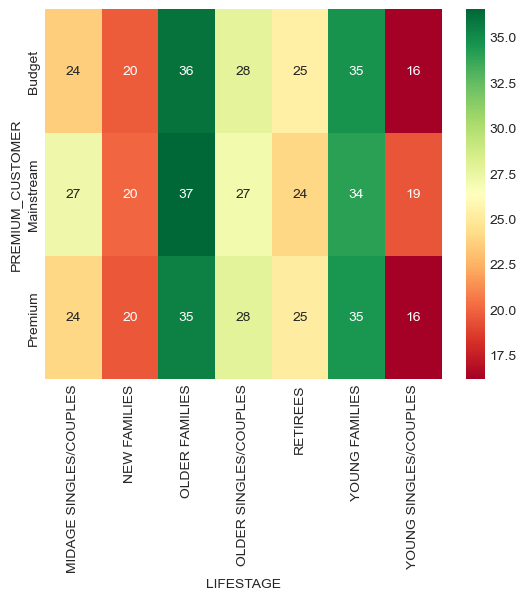

In [56]:
sns.heatmap(cs,
           annot = True,
            cmap = 'RdYlGn'
           )

1) We can see that Young Families and Older Families tend do spend on chips way more then people in other lifestage. On the countrary Young Singles/Couples and New Families spend well below average. 
2) Lifestage has higher impact on total sspending then our segmentation

## Customer spending per packet & Customer spending per kg

In [57]:
cspp = aggregate.pivot_table(index = 'PREMIUM_CUSTOMER',
                    columns = 'LIFESTAGE',
                   values = 'PACK_PRICE',
                   aggfunc = 'mean')

In [58]:
cspp

LIFESTAGE,MIDAGE SINGLES/COUPLES,NEW FAMILIES,OLDER FAMILIES,OLDER SINGLES/COUPLES,RETIREES,YOUNG FAMILIES,YOUNG SINGLES/COUPLES
PREMIUM_CUSTOMER,,,,,,,
Budget,3.732,3.895,3.811,3.900,3.958,3.835,3.596
Mainstream,4.077,3.900,3.811,3.811,3.835,3.800,4.142
Premium,3.766,3.866,3.781,3.936,3.964,3.826,3.591


<Axes: xlabel='LIFESTAGE', ylabel='PREMIUM_CUSTOMER'>

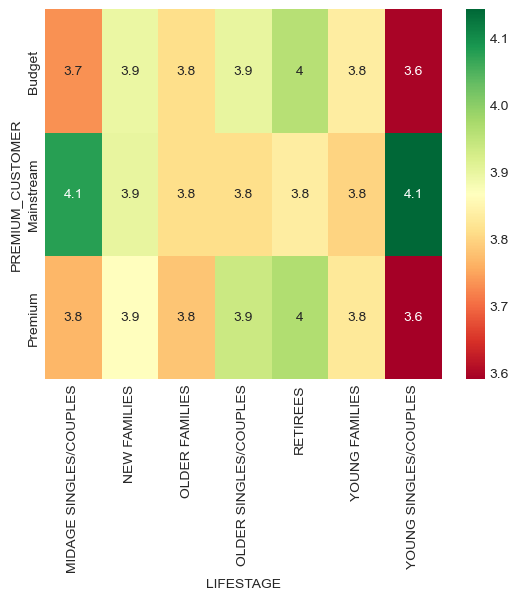

In [59]:
sns.heatmap(cspp,
           annot = True,
            cmap = 'RdYlGn'
           )

In [60]:
##  Customer spending per kg

In [61]:
cspkg = aggregate.pivot_table(index = 'PREMIUM_CUSTOMER',
                    columns = 'LIFESTAGE',
                   values = 'KG_PRICE',
                   aggfunc = 'mean')

In [62]:
cspkg

LIFESTAGE,MIDAGE SINGLES/COUPLES,NEW FAMILIES,OLDER FAMILIES,OLDER SINGLES/COUPLES,RETIREES,YOUNG FAMILIES,YOUNG SINGLES/COUPLES
PREMIUM_CUSTOMER,,,,,,,
Budget,22.080,23.033,22.251,22.994,23.052,22.352,21.286
Mainstream,23.708,22.900,22.266,22.488,22.565,22.351,24.013
Premium,22.109,22.784,22.264,22.957,23.130,22.572,21.296


<Axes: xlabel='LIFESTAGE', ylabel='PREMIUM_CUSTOMER'>

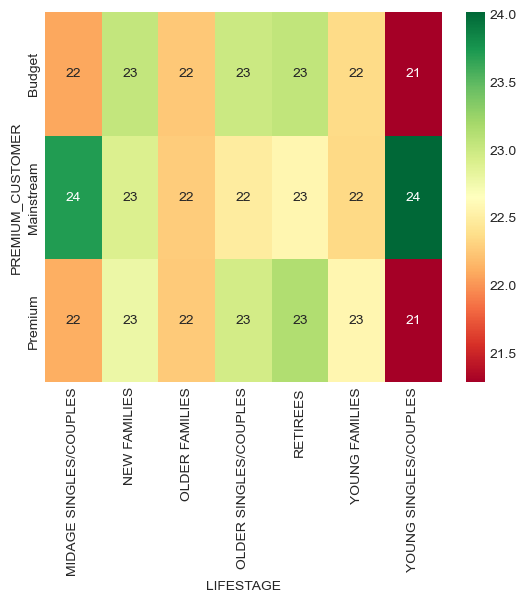

In [63]:
sns.heatmap(cspkg,
           annot = True,
            cmap = 'RdYlGn'
           )

From 2 heatmaps above we can see that mainstream customers, not Married buy most expensive chips on average. At the same time Budget and Preminum clients at these lifestages ted to buy cheapest chips. 

Another big opening is that Young Families and Older Families who spend most on Chips in general, tend to buy cheaper chips. I guess here we could make an assumption that groups with higher total chips consumption are probably more mindful about chips price.

## Packs bought per purchase & Preferred pack size

### Packs bought per purchase

In [64]:
pbpp = aggregate.pivot_table(index = 'PREMIUM_CUSTOMER',
                    columns = 'LIFESTAGE',
                   values = 'PROD_QTY',
                   aggfunc = 'mean')

In [65]:
pbpp

LIFESTAGE,MIDAGE SINGLES/COUPLES,NEW FAMILIES,OLDER FAMILIES,OLDER SINGLES/COUPLES,RETIREES,YOUNG FAMILIES,YOUNG SINGLES/COUPLES
PREMIUM_CUSTOMER,,,,,,,
Budget,1.798,1.776,1.867,1.846,1.821,1.860,1.711
Mainstream,1.846,1.791,1.870,1.839,1.810,1.852,1.792
Premium,1.797,1.797,1.869,1.845,1.837,1.848,1.703


<Axes: xlabel='LIFESTAGE', ylabel='PREMIUM_CUSTOMER'>

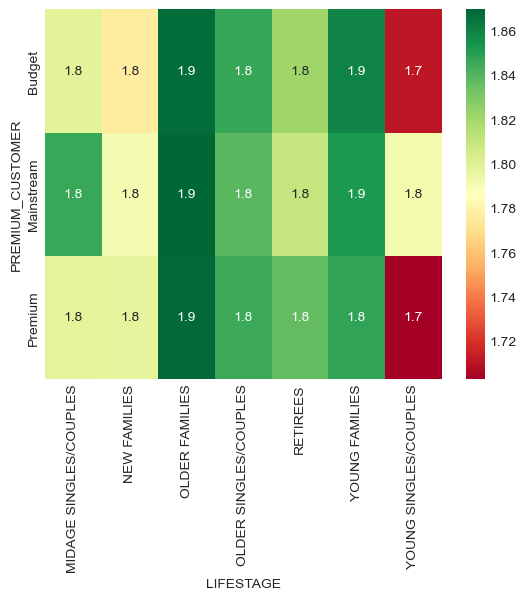

In [66]:
sns.heatmap(pbpp,
           annot = True,
            cmap = 'RdYlGn'
           )

### pack sizes

In [67]:
df['WEIGHT_CAT'].value_counts(ascending = False)

big        201439
XXL         40407
XL          18473
regular      4515
Name: WEIGHT_CAT, dtype: int64

We can see that BIG size (100-180 g) dominates heavily in our dataset.

In [68]:
agg2 = df.pivot_table(index = ['LIFESTAGE', 'PREMIUM_CUSTOMER'],
                        columns = 'WEIGHT_CAT',
                        values = 'WEIGHT',
                        aggfunc = 'count')


agg2

<Axes: xlabel='WEIGHT_CAT', ylabel='LIFESTAGE-PREMIUM_CUSTOMER'>

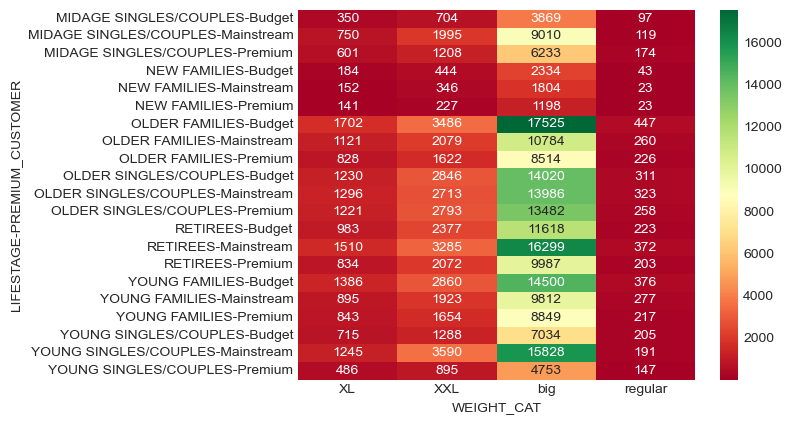

In [69]:
sns.heatmap(agg2,
           annot = True,
            cmap = 'RdYlGn',
            fmt="g"
           )

Here we can see pack size preference separtely for each segment. 

In [70]:
df

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_PRICE,WEIGHT,KG_PRICE,PRICE_CAT,WEIGHT_CAT
0,1000,YOUNG SINGLES/COUPLES,Premium,43390,1,5,Natural Chip Compny SeaSalt175g,2,6.000,3.000,0.175,17.143,average,big
1,1002,YOUNG SINGLES/COUPLES,Mainstream,43359,1,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.700,2.700,0.150,18.000,average,big
2,1003,YOUNG FAMILIES,Budget,43531,1,52,Grain Waves Sour Cream&Chives 210G,1,3.600,3.600,0.210,17.143,average,XL
3,1003,YOUNG FAMILIES,Budget,43532,1,106,Natural ChipCo Hony Soy Chckn175g,1,3.000,3.000,0.175,17.143,average,big
4,1004,OLDER SINGLES/COUPLES,Mainstream,43406,1,96,WW Original Stacked Chips 160g,1,1.900,1.900,0.160,11.875,below average,big
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264831,2370701,YOUNG FAMILIES,Mainstream,43442,88,24,Grain Waves Sweet Chilli 210g,2,7.200,3.600,0.210,17.143,average,XL
264832,2370751,YOUNG FAMILIES,Premium,43374,88,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.200,4.600,0.150,30.667,expensive,big
264833,2370961,OLDER FAMILIES,Budget,43397,88,70,Tyrrells Crisps Lightly Salted 165g,2,8.400,4.200,0.165,25.455,expensive,big
264834,2370961,OLDER FAMILIES,Budget,43400,88,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.200,5.100,0.300,17.000,average,XXL


## Additional plots visualisations for enhanced data understanding

In [71]:
df['WEIGHT'].describe()

count   264834.000
mean         0.182
std          0.064
min          0.070
25%          0.150
50%          0.170
75%          0.175
max          0.380
Name: WEIGHT, dtype: float64

In [72]:
df['PACK_PRICE'].describe()

count   264834.000
mean         3.825
std          1.110
min          1.320
25%          3.000
50%          3.800
75%          4.600
max          6.500
Name: PACK_PRICE, dtype: float64

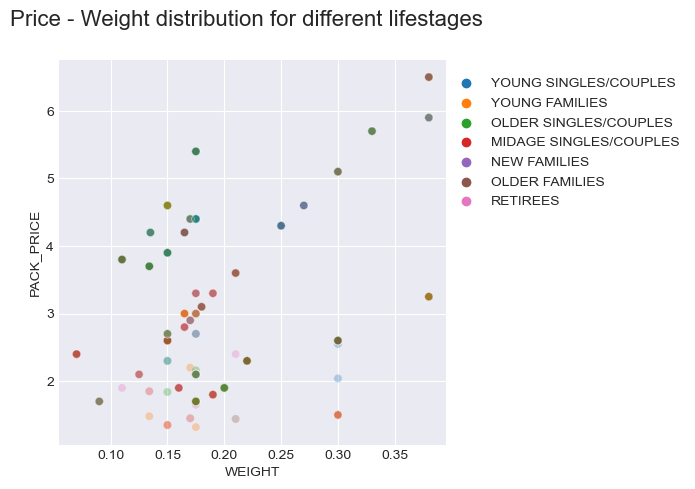

In [73]:
fig, ax = plt.subplots(figsize = (5,5))

sns.scatterplot(x='WEIGHT', y = 'PACK_PRICE',
                data = df, hue = 'LIFESTAGE',
               alpha = 0.3)
ax.legend(loc = (1, 0.6))
fig.suptitle('Price - Weight distribution for different lifestages', fontsize = 16)

plt.show()

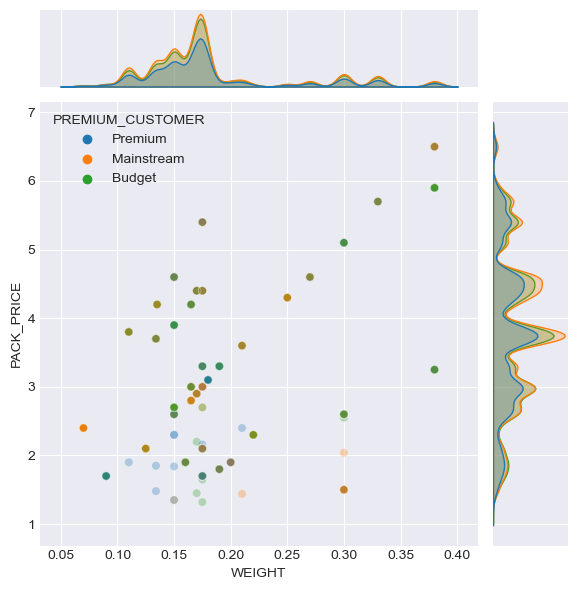

In [74]:
sns.jointplot(x='WEIGHT', y = 'PACK_PRICE',
                data = df, 
              hue = 'PREMIUM_CUSTOMER',
               alpha = 0.3)
plt.show()

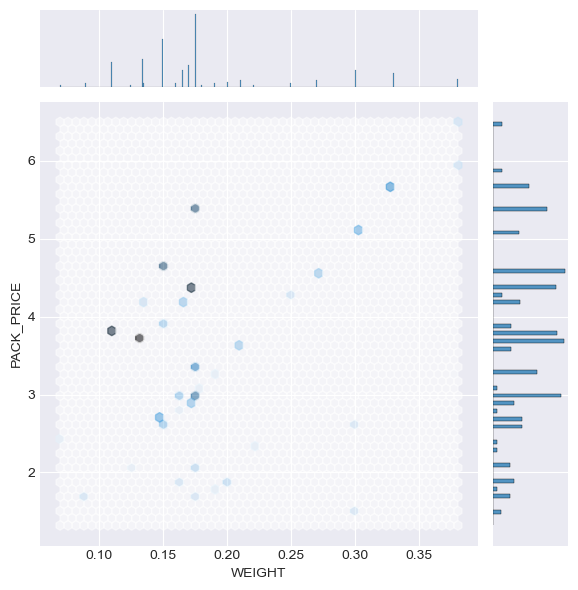

In [75]:
sns.jointplot(x='WEIGHT', y = 'PACK_PRICE',
                data = df, 
              kind = 'hex',
               alpha = 0.5)

plt.show()

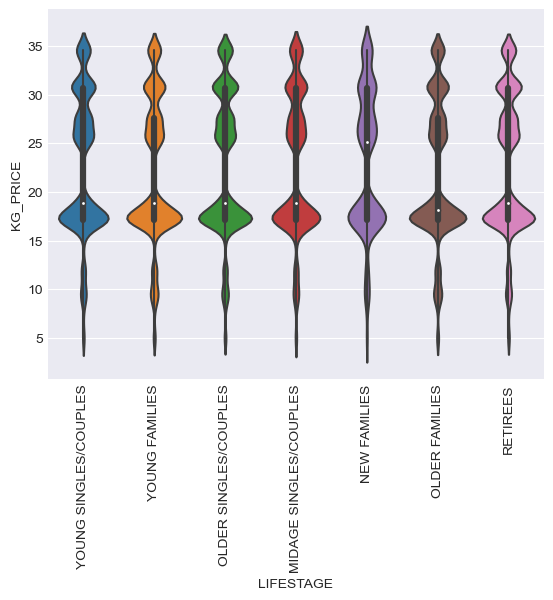

In [76]:
sns.violinplot(y='KG_PRICE', x = 'LIFESTAGE',
               data = df,
               paltette = 'husl')
plt.xticks(rotation = 90)
sns.despine()

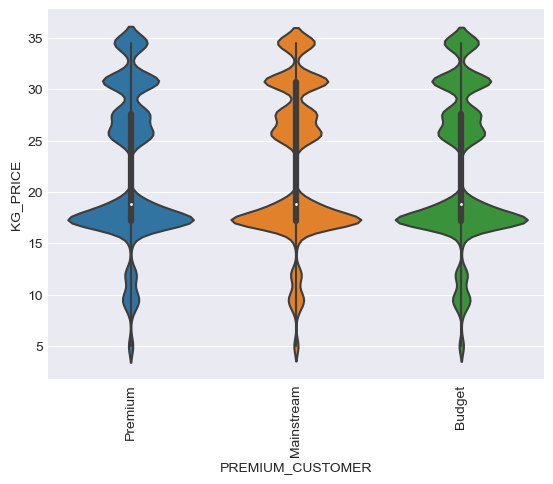

In [77]:
sns.violinplot(y='KG_PRICE', x = 'PREMIUM_CUSTOMER',
               data = df,
               paltette = 'husl')
plt.xticks(rotation = 90)
sns.despine()

# Summary

* The data was checked, cleaned and merged and now ready for any further analysis.
* Additional features were created and provide us with advancd options for segment analysis.
* 'PREMIUM CUSTOMER' segmentation doesnt seem tomake tremendous impact for our analysis. 'LIFESTAGE' appears to be much more valuable.
* Younger Families and Older Families spend much more on chips and tend to buy cheaper chips at the same time.
* Big packs 100-180 grams are most popular among all segments. 